# Functional analysis of single-cell transcriptomics

## Introduction

Single-cell transcriptomics yield many molecular readouts that one by one are
hard to interpret. Functional analysis or "enrichment" tries to summarize this
information into interpretable concepts using prior knowledge, making it easier
to characterize the biological context being studied. 

The goals of this tutorial are to:

- Introduce the functional analysis concept
- Learn how to run functional analysis
- Understand the differences in functional modeling
- Interpret the obtained scores

To do so, we will analyse a downsampled single-cell transcriptomics dataset
consisting of human immune cells from healthy and COVID-19 infected patients.
We leverage the tool [decoupler](https://decoupler-py.readthedocs.io/en/latest/), which contains enrichment methods
to obtain biological activities from omics data.

## Dependencies
To be able to run the code, we first need to load
the required packages.

In [1]:
# Single-cell processing
import scanpy as sc

# Enrichment analysis
import decoupler as dc

# Data handling
import pandas as pd
import numpy as np

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Data loading
To load the processed dataset run. With this we obtain an `AnnData` object:

In [2]:
adata = sc.read_h5ad('data/covid.h5ad')
adata

AnnData object with n_obs × n_vars = 2408 × 15763
    obs: 'disease', 'leiden'
    uns: 'disease_colors', 'leiden_colors', 'log1p'
    obsm: 'X_umap'



Inside an `AnnData` object we have different attributes, here are the most important ones:

* X: This is where the main assay is stored, in this case log-transformed normalized counts
* obs: Metadata dataframe for cells (rows)
* var: Metadata dataframe for genes (columns)

You can read more about it in the official [documentation](https://anndata.readthedocs.io/en/latest/index.html)

<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg"
     width="400" 
     height="500" />

What can you tell about this already processed dataset? Explore its metadata and
try to plot some of its attributes with `sc.pl.umap`:

<div class="alert alert-info">

**Note**
    
If you want to know how to use a function, you can run `?` followed with the function name. Example `?sc.pl.umap`.

</div>  

/home/badi/miniconda3/envs/func/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/badi/miniconda3/envs/func/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


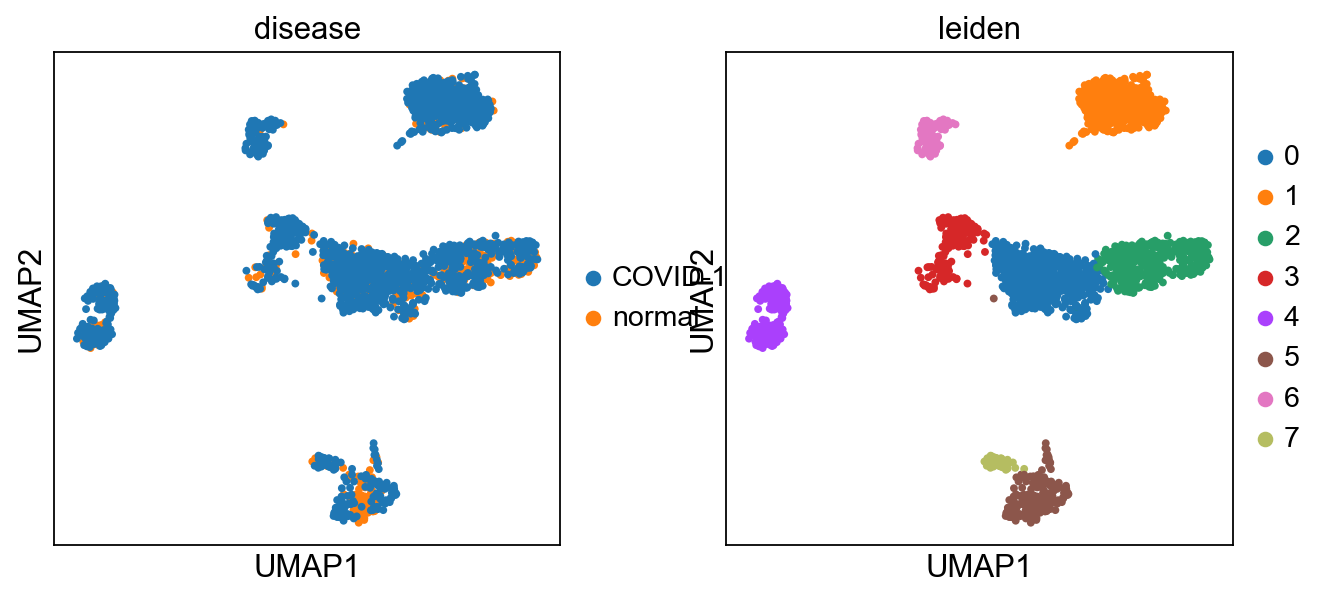

,disease,leiden
13-AACAGGGAGATCACTC,normal,2
13-AACCAACGTGTGAGCA,normal,2
13-AACCCAAGTTAAACCC,normal,5
13-AAGCGAGTCGAATCCA,normal,0
13-AATAGAGTCCTTATCA,normal,5
...,...,...
22-TTCCGGTGTCTCGACG,COVID-19,3
22-TTCTAGTAGAATGTTG,COVID-19,0
22-TTGGTTTCACTGATTG,COVID-19,0
22-TTGTTTGCACACACTA,COVID-19,0


In [3]:
# Explore adata
sc.pl.umap(adata, color=['disease', 'leiden'])

adata.obs

## Cell type annotation

In single-cell data, we have no prior information of which cell type each cell
belongs. To assign cell type labels, we first project all cells in a shared
embedded space, then we find communities of cells that show a similar
transcription profile and finally we check what cell type specific markers are
expressed. These genes are mainly expressed exclusively by a specific
cell type, making them useful to distinguish heterogeneous groups of cells.
Marker genes were discovered and annotated in previous studies and there are
some resources that collect and curate them. If more than one marker gene is
available, statistical methods can be used to test if a set of markers is
enriched in a given cell population.

`PanglaoDB` is a database of cell type markers, which can be easily accessed
using a wrapper to `OmniPath` from `decoupler`:

```python
# Retrieving via decoupler
markers = dc.get_resource('PanglaoDB')
```

However, for stability of this tutorial we are using a fixed version:

In [4]:
markers = pd.read_csv('data/panglaodb.csv')
markers

,genesymbol,cell_type,organ,organism
0,CTRB1,Acinar cells,Pancreas,human
1,KLK1,Endothelial cells,Vasculature,human
2,KLK1,Principal cells,Kidney,human
3,KLK1,Acinar cells,Pancreas,human
4,KLK1,Plasmacytoid dendritic cells,Immune system,human
...,...,...,...,...
5497,SLC14A1,Urothelial cells,Urinary bladder,human
5498,UPK3A,Urothelial cells,Urinary bladder,human
5499,UPK1A,Urothelial cells,Urinary bladder,human
5500,UPK2,Urothelial cells,Urinary bladder,human


Take a look how the resource is organized. Can you filter by relevant 
information? Think of a filtering strategy that will help the annotation of your
dataset.

In [5]:
# Filter relevant information
markers = markers[(markers['organ'] == 'Immune system') & (markers['organism'] == 'human')]
markers

,genesymbol,cell_type,organ,organism
4,KLK1,Plasmacytoid dendritic cells,Immune system,human
44,GDF15,Macrophages,Immune system,human
80,LYZ,Neutrophils,Immune system,human
83,LYZ,Dendritic cells,Immune system,human
92,CEBPA,Basophils,Immune system,human
...,...,...,...,...
5441,FOXP3,T regulatory cells,Immune system,human
5442,FOXP3,T helper cells,Immune system,human
5444,NR3C1,T helper cells,Immune system,human
5445,CTLA4,T regulatory cells,Immune system,human


Once filtered, we will use the resource `PanglaoDB` and the method Over Representation Analysis (ORA) to see which cells are
enriched by cell type marker genes.

In [6]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 2408 samples and 15763 targets for 23 sources.


100%|████████████████████████████████████| 2408/2408 [00:02<00:00, 1071.13it/s]


In [7]:
adata.obsm['ora_estimate']

source,B cells,B cells memory,B cells naive,Basophils,Dendritic cells,Eosinophils,Gamma delta T cells,Macrophages,Mast cells,Megakaryocytes,...,Neutrophils,Nuocytes,Plasma cells,Plasmacytoid dendritic cells,Red pulp macrophages,T cells,T follicular helper cells,T helper cells,T memory cells,T regulatory cells
13-AACAGGGAGATCACTC,1.024830,0.692025,1.580235,0.431672,2.068762,0.803695,2.345477,0.169821,0.068623,0.262298,...,0.046004,0.7392,0.828815,0.292256,-0.00000,12.164301,0.944056,0.887282,0.944056,0.416633
13-AACCAACGTGTGAGCA,1.024830,0.383950,1.107570,0.190968,3.603085,0.287705,2.345477,1.054574,0.363416,0.565116,...,0.178156,0.7392,0.828815,0.619709,-0.00000,12.164301,0.944056,2.523971,0.944056,-0.000000
13-AACCCAAGTTAAACCC,1.540940,0.166252,1.580235,1.186404,16.357254,0.803695,0.326151,11.530124,0.068623,1.467441,...,9.423545,-0.0000,1.214722,0.619709,0.44636,0.970893,0.944056,0.323365,0.944056,-0.000000
13-AAGCGAGTCGAATCCA,0.281862,0.383950,1.580235,0.190968,1.253410,0.803695,2.345477,0.314460,0.014320,0.074004,...,0.728199,0.7392,0.110274,0.084510,-0.00000,14.584816,-0.000000,1.632103,0.944056,0.416633
13-AATAGAGTCCTTATCA,1.540940,0.042256,0.395316,1.186404,10.813500,1.493853,0.326151,9.881517,1.296506,1.467441,...,5.744015,-0.0000,0.512515,0.084510,0.44636,1.467441,-0.000000,-0.000000,0.944056,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22-TTCCGGTGTCTCGACG,0.600850,0.383950,0.172095,0.190968,1.253410,0.803695,2.345477,0.075124,0.182388,0.970893,...,0.407049,-0.0000,0.271689,0.292256,0.44636,7.810159,-0.000000,0.887282,0.944056,-0.000000
22-TTCTAGTAGAATGTTG,1.024830,1.547848,1.580235,0.190968,2.068762,0.803695,1.144389,0.314460,0.014320,0.074004,...,0.178156,0.7392,0.828815,0.292256,-0.00000,13.355040,-0.000000,0.887282,0.944056,-0.000000
22-TTGGTTTCACTGATTG,0.600850,0.692025,1.580235,0.190968,0.916279,0.287705,1.703076,0.023929,-0.000000,0.074004,...,0.407049,0.7392,0.828815,-0.000000,-0.00000,11.013377,-0.000000,0.323365,0.944056,-0.000000
22-TTGTTTGCACACACTA,0.281862,0.383950,1.580235,0.431672,3.053386,0.287705,1.144389,0.510895,0.014320,-0.000000,...,0.728199,0.7392,0.828815,0.084510,0.44636,7.810159,0.944056,0.323365,0.944056,-0.000000


For each cell, we now have an enrichment score for each cell type in our resource. We can extract these scores in a new `AnnData` object:

In [8]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 2408 × 23
    obs: 'disease', 'leiden'
    var: 'mean', 'std'
    uns: 'disease_colors', 'leiden_colors', 'log1p'
    obsm: 'X_umap', 'ora_estimate', 'ora_pvals'

With `decoupler` we can also identify which are the top predicted cell types per cluster using the 
function `dc.rank_sources_groups`. Here, it identifies "marker" cell types per cluster using
same statistical tests available in scanpy's `scanpy.tl.rank_genes_groups`.

In [9]:
# Extract top cell types per cluster
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T cells,31.436127,1.263114,5.290040e-160,1.216709e-158
1,0,rest,Nuocytes,29.487408,1.335935,5.412094e-146,6.223908e-145
2,0,rest,T memory cells,14.007777,0.745185,1.235846e-41,3.158273e-41
3,0,rest,T helper cells,10.599389,0.561844,2.701662e-25,5.648929e-25
4,0,rest,T follicular helper cells,6.853286,0.379101,1.102272e-11,1.584515e-11
...,...,...,...,...,...,...,...
179,7,rest,Gamma delta T cells,-2.811825,-0.422032,7.173447e-03,1.649893e-02
180,7,rest,NK cells,-3.551210,-0.530540,8.959881e-04,2.289747e-03
181,7,rest,T helper cells,-3.901082,-0.682925,2.046205e-04,5.882840e-04
182,7,rest,Nuocytes,-4.692728,-0.695439,2.539830e-05,9.736014e-05


We can then extract the top 3 predicted cell types per cluster:

In [10]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['T cells', 'Nuocytes', 'T memory cells'],
 '1': ['Neutrophils', 'Megakaryocytes', 'Monocytes'],
 '2': ['NK cells', 'Gamma delta T cells', 'T cells'],
 '3': ['Gamma delta T cells', 'Nuocytes', 'NK cells'],
 '4': ['B cells naive', 'B cells', 'B cells memory'],
 '5': ['Dendritic cells', 'Macrophages', 'Monocytes'],
 '6': ['Megakaryocytes', 'Mast cells', 'Red pulp macrophages'],
 '7': ['Macrophages', 'Dendritic cells', 'Monocytes']}

We can visualize the obtained top predicted cell types:

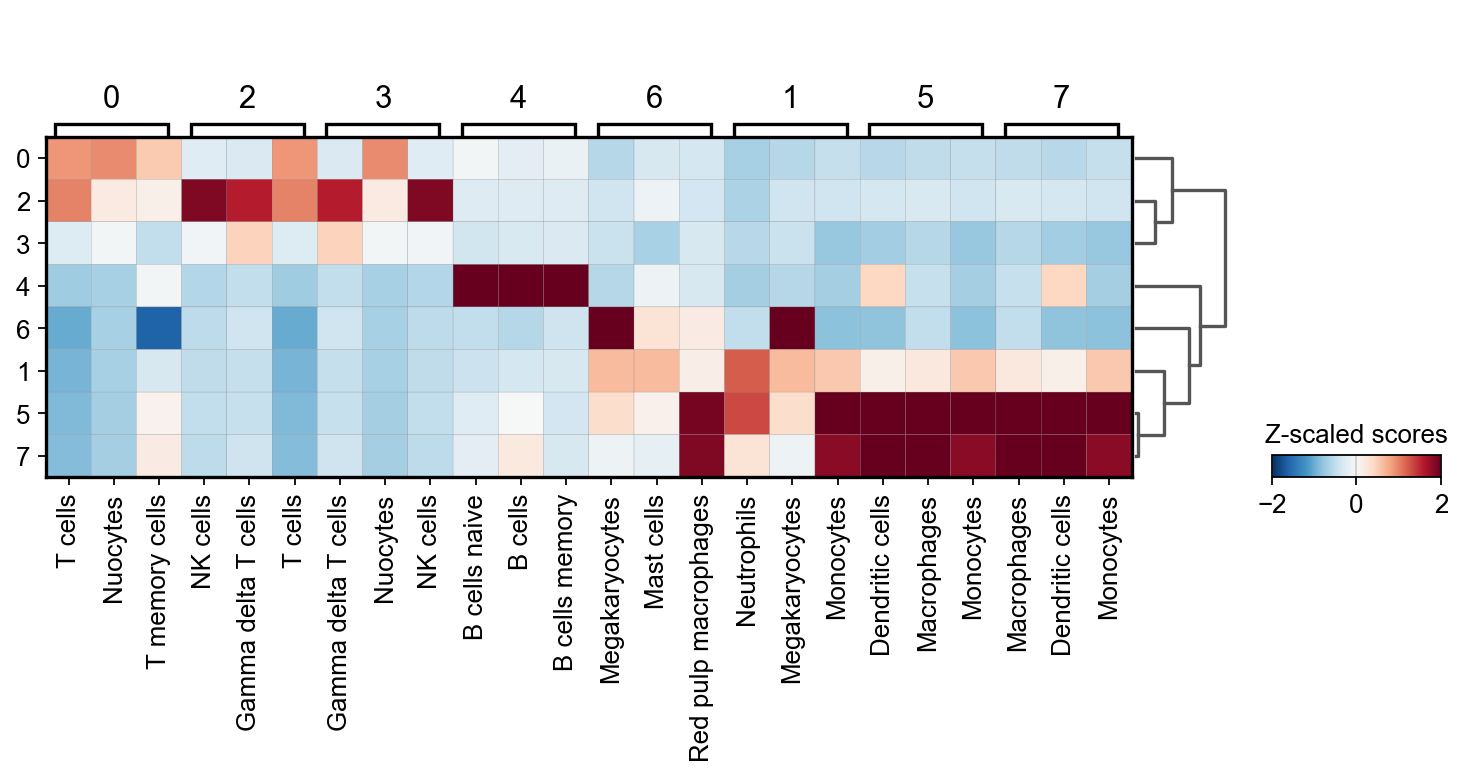

In [11]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True,
                 colorbar_title='Z-scaled scores', vmin=-2, vmax=2, cmap='RdBu_r')

Can you come up with an annotation for this atlas? You can use `sc.pl.violin` and `sc.pl.umap` to explore the obtained scores.

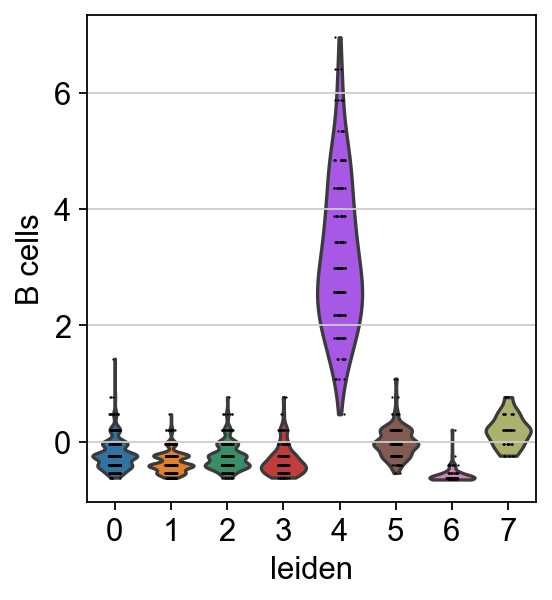

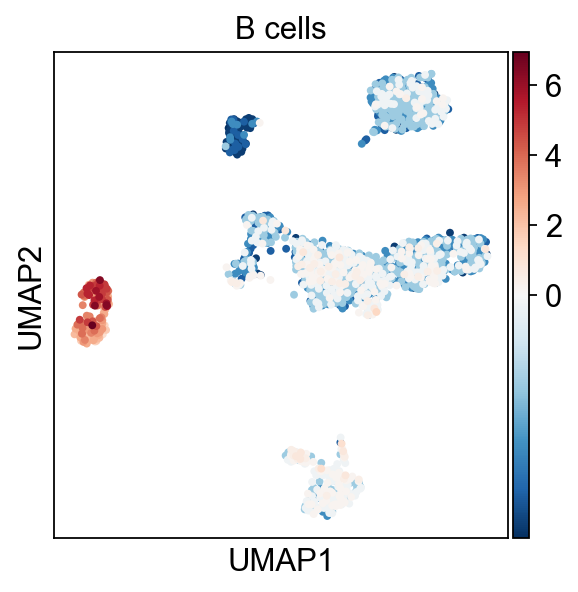

In [12]:
# Explore data
sc.pl.violin(acts, keys='B cells', groupby='leiden')
sc.pl.umap(acts, color='B cells', cmap='RdBu_r', vcenter=0)

In [13]:
# Final anntoation
ann_dict = {
    '0': 'T cells',
    '1': 'Neutrophils',
    '2': 'T cells',
    '3': 'T cells',
    '4': 'B cells',
    '5': 'Monocytes',
    '6': 'Plaletets',
    '7': 'Monocytes',
}

adata.obs['cell_type'] = [ann_dict[clust] for clust in adata.obs['leiden']]

We can visualize how the final annotation looks like:

/home/badi/miniconda3/envs/func/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


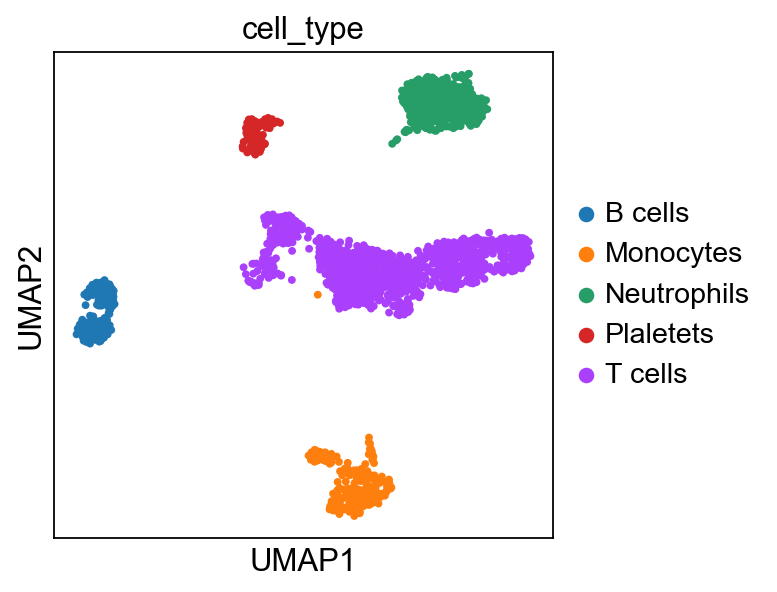

In [14]:
sc.pl.umap(adata, color='cell_type')

## Transcription factor activity inference
Transcription factors (TF) are proteins that regulate the expression of specific 
target genes. Gene regulation can be represented as a Gene Regulatory Network
(GRN), where TFs regulate downstream target genes (which can be other TFs). 

[DoRothEA](https://saezlab.github.io/dorothea/) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets. Since
these regulons were gathered from different types of evidence, interactions in
DoRothEA are classified in different confidence levels, ranging from A (highest
confidence) to D (lowest confidence). Moreover, each interaction is weighted by
its confidence level and the sign of its mode of regulation (activation or
inhibition).

It can be easily accessed using a wrapper to `OmniPath` from `decoupleR`.

```python
# Retrieving via decoupler
dorothea = dc.get_dorothea()
```

However, like in the previous example we will work with a fixed version:

In [15]:
dorothea = pd.read_csv('data/dorothea.csv')
dorothea

,source,target,weight,confidence
0,ADNP,ATF7IP,0.333333,C
1,ADNP,DYRK1A,0.333333,C
2,ADNP,TLK1,0.333333,C
3,ADNP,ZMYM4,0.333333,C
4,AHR,ARHGAP15,0.333333,C
...,...,...,...,...
32272,ZNF766,MARF1,0.333333,C
32273,ZNF83,CUBN,0.333333,C
32274,ZNF83,PCBP1,0.333333,C
32275,ZNF83,SND1,0.333333,C


Explore a little bit the obtained network. How many interactions are coming
from each confidence level? What is the distribution of mode of regulations?
What is the distribution of number of target genes per TF?

In [16]:
# Explore dorothea




Afterwards, we will give the gene expression and `DoRothEA` to
the method univariate linear model (ULM), which will infer activity scores for each TF
in each cell.

In [17]:
%%time
dc.run_ulm(
    mat=adata,
    net=dorothea,
    source='source',
    target='target',
    weight='weight',
    min_n=10,
    verbose=True,
    use_raw=False
)

Running ulm on mat with 2408 samples and 15763 targets for 264 sources.
CPU times: user 7min 1s, sys: 1.36 s, total: 7min 3s
Wall time: 1min


In [18]:
adata.obsm['ulm_estimate']

,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,ZKSCAN1,ZNF143,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF592,ZNF639,ZNF740
13-AACAGGGAGATCACTC,1.099014,2.438833,1.240303,0.729360,0.269832,-0.131112,0.628622,1.631416,6.804163,1.379589,...,1.414211,0.031086,0.979751,-0.664768,-2.669750,-0.366739,1.232103,0.648340,3.451440,0.913979
13-AACCAACGTGTGAGCA,0.727860,2.802898,2.637721,1.209185,0.792347,0.273951,0.715679,2.313607,9.358383,3.475263,...,1.472191,0.942300,2.124990,-1.069427,-1.637183,-0.358786,2.276571,0.876880,3.758843,1.078188
13-AACCCAAGTTAAACCC,1.218108,2.608539,3.122200,2.020323,2.262414,0.650849,0.217792,3.098185,5.324158,3.481380,...,1.689083,2.790776,1.488739,-0.406999,-1.176521,-0.171393,4.635152,-0.416906,2.725951,2.520968
13-AAGCGAGTCGAATCCA,1.738327,1.806818,0.466718,1.184685,0.342770,0.052702,-0.047119,1.482023,6.285349,-0.112034,...,0.429906,1.024738,0.919011,-1.109600,-3.068462,-0.260429,1.155551,-0.256393,2.878160,1.385557
13-AATAGAGTCCTTATCA,2.250314,2.771451,4.425803,2.741788,4.254273,1.419167,1.753712,5.316946,6.483617,2.781436,...,1.907255,2.383849,3.542042,0.670511,1.809574,0.483127,4.747989,-0.632863,2.025720,1.352378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22-TTCCGGTGTCTCGACG,-0.917458,1.316768,0.131337,-0.733873,-1.061308,-0.640532,-0.105307,-0.415051,1.632230,3.476829,...,0.987302,-1.092912,1.152834,-0.693374,-2.267828,-0.685808,-0.609871,-0.611419,1.208319,-0.068518
22-TTCTAGTAGAATGTTG,2.012556,1.806187,1.853680,1.761843,1.402553,-1.190145,1.071139,1.657200,4.012546,1.965486,...,1.625125,-0.399644,2.306586,-0.399214,-1.028790,0.038533,1.684501,0.106708,2.135029,0.440654
22-TTGGTTTCACTGATTG,-0.505055,1.082189,0.476842,0.273486,1.095120,-1.262325,0.221555,1.403206,2.494413,2.045140,...,0.647138,-0.345514,0.878732,-1.090453,-2.315793,0.413066,2.856938,0.476082,1.761022,0.872418
22-TTGTTTGCACACACTA,0.776684,3.363681,0.489465,0.819281,0.535250,-1.188960,0.370383,2.231946,2.759374,1.922721,...,0.636925,0.473643,0.554520,0.028161,-2.229980,0.913695,2.020676,-0.987368,-0.109636,1.007302


For each cell, we now have an enrichment score for each TF in our network. We can extract these scores in a new `AnnData` object:

In [19]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 2408 × 264
    obs: 'disease', 'leiden', 'cell_type'
    var: 'mean', 'std'
    uns: 'disease_colors', 'leiden_colors', 'log1p', 'dendrogram_leiden', 'cell_type_colors'
    obsm: 'X_umap', 'ora_estimate', 'ora_pvals', 'ulm_estimate', 'ulm_pvals'

Like before, we can test which are the top active TFs per cluster or cell type:

In [20]:
# Extract top cell types per cluster
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,RFX5,36.988358,2.616152,1.276444e-120,3.369813e-118
1,B cells,rest,POU2F1,19.613882,1.710178,9.328766e-58,1.231397e-55
2,B cells,rest,PAX5,17.674903,1.859780,1.066361e-49,9.383976e-48
3,B cells,rest,CREB1,14.984835,1.316377,8.540150e-39,5.636499e-37
4,B cells,rest,POU2F2,13.984881,1.189938,2.599902e-34,1.372748e-32
...,...,...,...,...,...,...,...
1315,T cells,rest,FOSL2,-43.057573,-1.311866,9.399650e-281,4.135846e-279
1316,T cells,rest,SPI1,-45.219643,-1.341916,2.831918e-315,2.492088e-313
1317,T cells,rest,POU2F2,-45.512319,-1.347843,6.674188e-316,8.809928e-314
1318,T cells,rest,CEBPA,-47.263281,-1.380842,8.482119e-320,2.239279e-317


Explore the results with `sc.pl.matrixplot`, `sc.pl.violin` and `sc.pl.umap`. Do these results make sense? Search some active TFs in the literature to
confirm.

In [21]:
n_tfs = 3
tfs_dict = df.groupby('group').head(n_tfs).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
tfs_dict

{'B cells': ['RFX5', 'POU2F1', 'PAX5'],
 'Monocytes': ['SPI1', 'HIF1A', 'ZEB2'],
 'Neutrophils': ['CEBPB', 'CEBPA', 'NFKB1'],
 'Plaletets': ['GATA1', 'SRF', 'FLI1'],
 'T cells': ['MYC', 'TBX21', 'NR2C2']}

         Falling back to preprocessing with `sc.pp.pca` and default params.


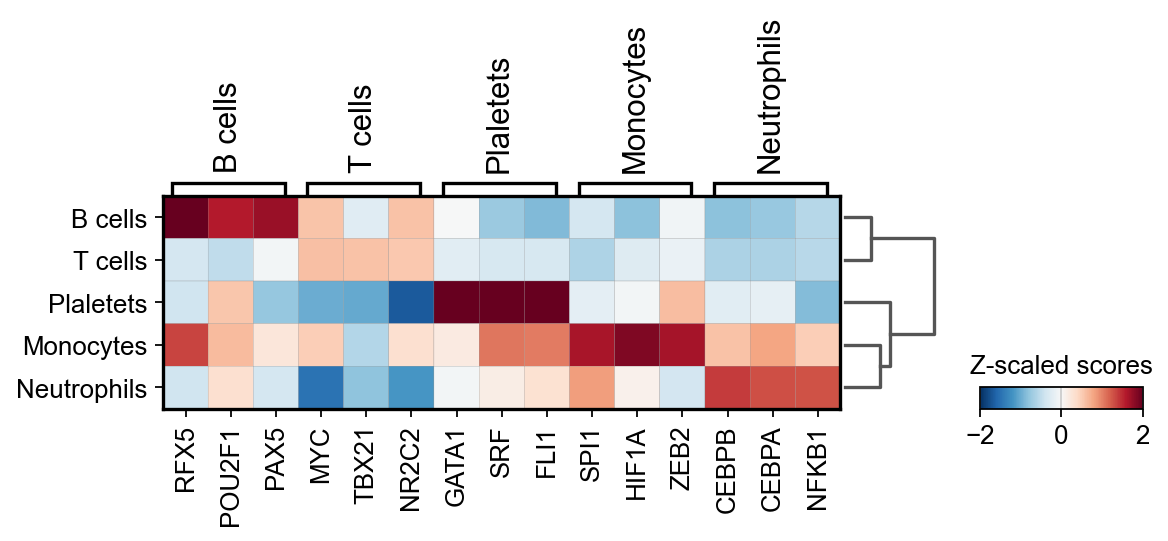

In [22]:
sc.pl.matrixplot(acts, tfs_dict, 'cell_type', dendrogram=True,
                 colorbar_title='Z-scaled scores', vmin=-2, vmax=2, cmap='RdBu_r')

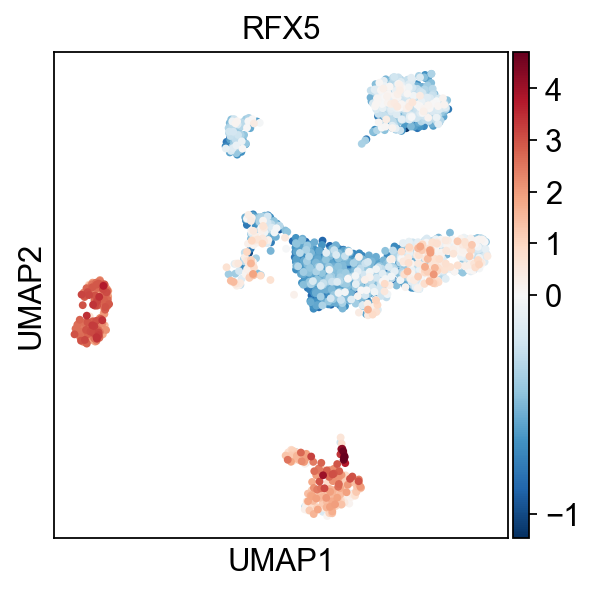

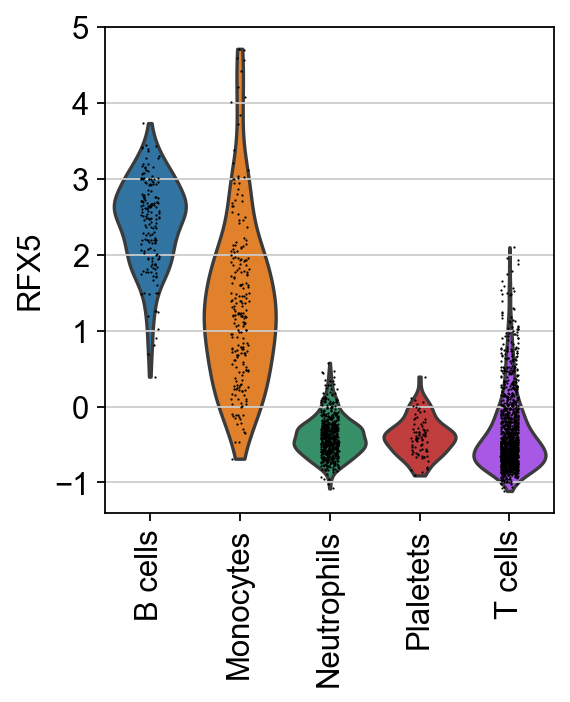

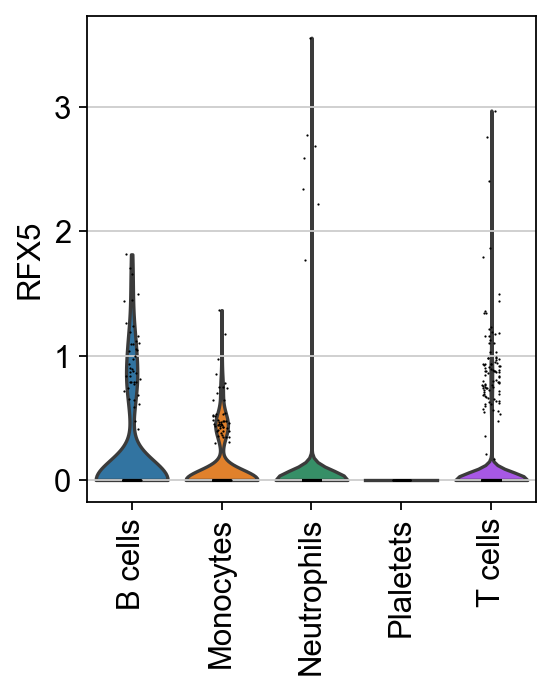

In [23]:
sc.pl.umap(acts, color='RFX5', cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys='RFX5', groupby='cell_type', rotation=90)
sc.pl.violin(adata, keys='RFX5', groupby='cell_type', rotation=90)

# Pathway activity inference

Cells activate or inhibit gene programs, called pathways, that module the cell
response to external changes. For example they can induce apoptosis if they are
targeted by immune cells or shift metabolism when oxygen is not available.

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource
containing a curated collection of pathways and their target genes, with
weights (activation or inhibition) and p-values for each interaction.

It can be easily accessed using a wrapper to `OmniPath` from `decoupleR`.

```python
progeny = dc.get_progeny()
```

But we will work with a fixed version:

In [24]:
progeny = pd.read_csv('data/progeny.csv')
progeny

,source,target,weight
0,Androgen,TMPRSS2,11.490631
1,Androgen,NKX3-1,10.622551
2,Androgen,MBOAT2,10.472733
3,Androgen,KLK2,10.176186
4,Androgen,SARG,11.386852
...,...,...,...
6995,p53,ZMYM4,-2.325751
6996,p53,CFDP1,-1.628168
6997,p53,VPS37D,2.309503
6998,p53,TEDC1,-2.274823


Explore the obtained dataframe. How many different pathways does PROGENy
contain. Discuss some of its pathways, what biological processes are they
regulating? Search literature if needed.

In the previous exercise, we estimated TF activities per cell type but we did
not explore the differences between healthy and COVID-19 patients. To do so,
first we will compute the Differential Expressed Genes (DEG) between conditions for a cell type of your choice.

In [25]:
# Select your cell type of choice
cell_type = 'T cells'

# Subset adata
sdata = adata[adata.obs['cell_type'] == cell_type]

# Run DEG between COVID and healthy
sdata.uns['log1p']["base"] = None # Might need this
sc.tl.rank_genes_groups(sdata, 'disease', method='t-test')

# Extract DEG
deg = sc.get.rank_genes_groups_df(sdata, group=None)
deg.head(10)

/home/badi/miniconda3/envs/func/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,COVID-19,HBB,18.730341,1.989534,3.520480e-66,2.774667e-62
1,COVID-19,HBA2,17.678448,2.016186,1.219868e-60,6.409591e-57
2,COVID-19,MTND1P23,16.648304,1.962445,2.078283e-56,8.189994e-53
3,COVID-19,MTND4P12,15.204955,6.271055,6.217156e-47,1.633351e-43
4,COVID-19,RPS4Y1,15.057010,5.234469,5.576119e-47,1.633351e-43
5,COVID-19,HBA1,14.827594,2.066639,2.614367e-45,5.887182e-42
6,COVID-19,DDX3Y,9.990639,4.770668,1.212219e-22,8.307919e-20
7,COVID-19,UTY,8.773314,26.715754,8.273290e-18,3.343894e-15
8,COVID-19,PRKY,8.382144,4.401215,1.628372e-16,5.461282e-14
9,COVID-19,USP9Y,8.300230,4.272798,2.604115e-16,8.551805e-14


What can you tell about the top DEG? Try looking at literature for meaning.

Results from DEG can be used for functional enrichment. Now we will use the
obtained logFCs and estimate pathway activities from them using ULM:

In [26]:
# Filter sign genes and transform to mat
mat = deg[deg['pvals_adj'] < 0.05].pivot(index='group', columns='names', values='logfoldchanges')
mat

names,A2M,AAK1,AASS,ABCB11,ABCC9,ABCG1,ABHD17A,ABI1,ABI2,ACAA2,...,ZNF600,ZNF605,ZNF623,ZNF66,ZNF665,ZNF76,ZNF805,ZNF890P,ZSCAN2,ZZEF1
group,,,,,,,,,,,,,,,,,,,,,
COVID-19,-1.490131,-0.302079,-0.852689,-0.261075,-0.554937,-0.639026,-0.467797,-0.496081,-0.656183,0.663549,...,-1.2193,-0.281596,-0.970123,-0.536161,-0.506143,-1.143167,-0.834425,23.331848,-1.053339,-0.34627
normal,1.490131,0.302079,0.852689,0.261075,0.554937,0.639026,0.467797,0.496081,0.656183,-0.663549,...,1.2193,0.281596,0.970123,0.536161,0.506143,1.143167,0.834425,-23.331848,1.053339,0.34627


In [27]:
enr_scores, enr_pvals = dc.run_ulm(
    mat=mat,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    min_n=10,
    verbose=True,
    use_raw=False
)

enr_scores

Running ulm on mat with 2 samples and 1238 targets for 14 sources.


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
COVID-19,-0.298266,-0.594828,0.563561,-0.64199,0.829477,-0.813662,-1.53092,0.43179,0.570245,-1.343161,0.206986,0.116585,0.196847,0.001542
normal,0.298266,0.594828,-0.563561,0.64199,-0.829477,0.813662,1.53092,-0.43179,-0.570245,1.343161,-0.206986,-0.116585,-0.196847,-0.001542


We can visualize the results:

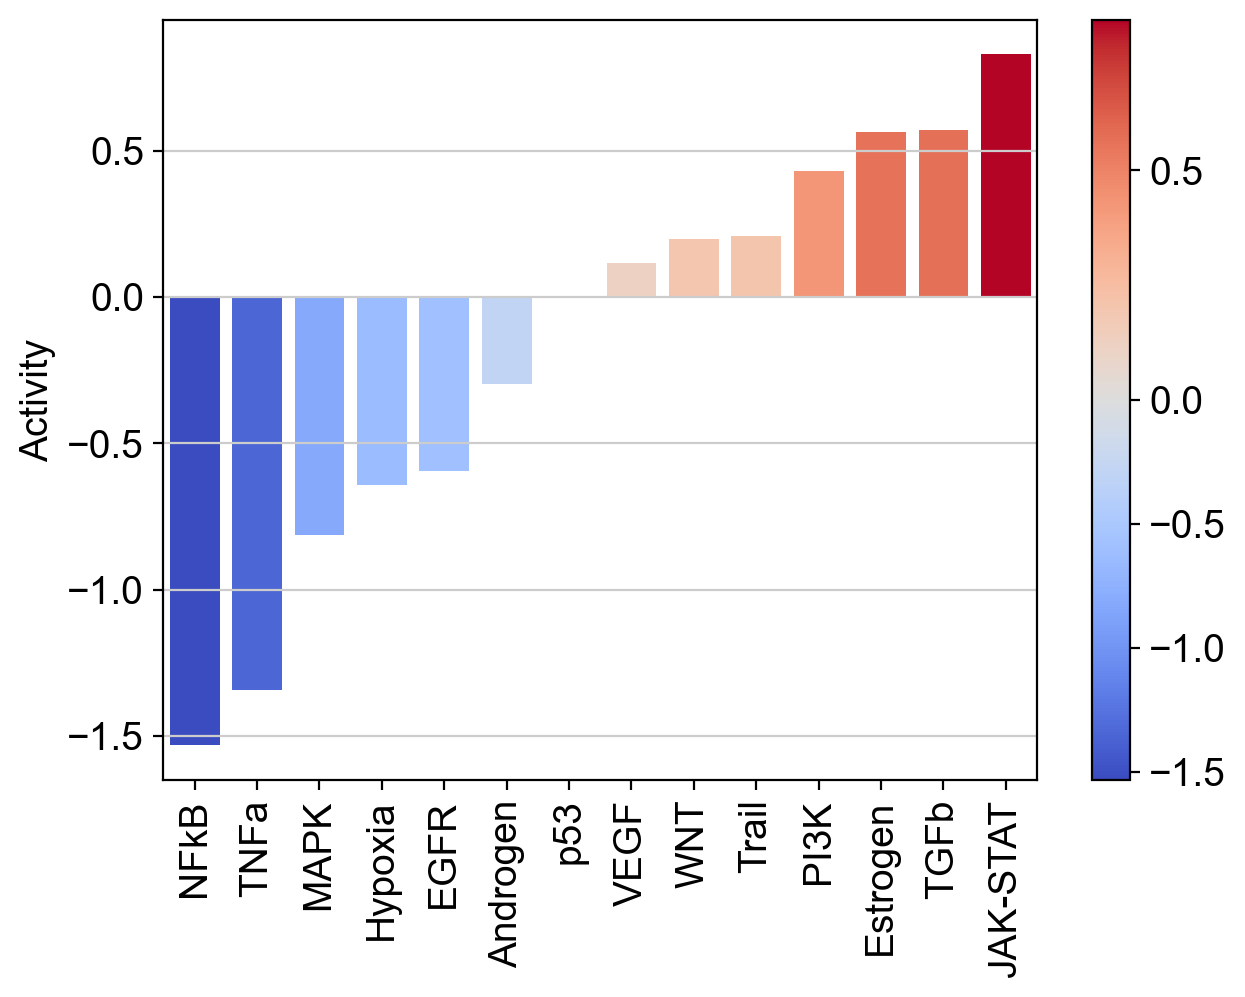

In [28]:
dc.plot_barplot(enr_scores, 'COVID-19', top=25, vertical=False)

Comment the obtained results. Do they make sense? Explore other cell types.